In [1]:
import json
import random
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score

In [2]:
import sys, os, json, random, logging, time, socket
import numpy as np
from itertools import cycle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from matplotlib import gridspec
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from matplotlib.backends.backend_pdf import PdfPages
from scipy import interp
from sklearn.preprocessing import MinMaxScaler
from sklearn import manifold
import matplotlib.pylab as pylab
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

In [3]:
malware_file = 'amd_malware_metadata/malware_post_pca_data.txt'

with open(malware_file, 'r') as data_file:
    mlw_data = json.load(data_file)

In [5]:
malware = []
for m in mlw_data.keys():
    for each_sample in mlw_data[m]:
        if len(malware) == 0:
            malware = np.array(each_sample)
        else:
            malware = np.vstack((malware, each_sample))


In [6]:
malware.shape

(31871, 12)

benign

In [7]:
benign_files = [\
        'amd_desktop_metadata/benign_post_pca_data.txt',\
        'amd_python_benign_metadata/python_benign_post_pca_data.txt'
        ]
malware_files = ['amd_malware_metadata/malware_post_pca_data.txt']

benign_data = []
for files in benign_files:
    with open(files, 'r') as data_file:
        json_data = json.load(data_file)

    for bm in json_data.keys():
        for each_sample in json_data[bm]:
            if benign_data == []:
                benign_data = np.array(each_sample) 
            else:
                benign_data = np.vstack((benign_data, each_sample))

    data_file.close()

/tmp/ipykernel_102933/2151485239.py:14: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if benign_data == []:


In [8]:
benign_data.shape

(45648, 12)

In [13]:
class learnAll:
    def __init__(self, malware, benign):
        self.malware_data = malware
        self.benign_data = benign

        malware_label = np.ones(len(malware))
        benign_label = np.zeros(len(benign_data))
        sample_size = min(len(benign_label), len(malware_label))
        self.data = np.vstack((
            random.sample(list(benign_data), sample_size),
            random.sample(list(malware), sample_size)
        ))
        self.label = np.concatenate((
            random.sample(list(benign_label), sample_size),
            random.sample(list(malware_label), sample_size)
        ))

    def setup_train_test_split(self):
        """
        Setup_train_test_split uses default split (scikit-learn split) to separate the 
        training and testing dataset.
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.data, self.label, test_size=0.1,
            random_state=random.randint(0, 2**32 - 1))

    def setup_classifiers(self):
        """
        setup_classifiers only generate the classifier class objects. nothing more.
        """
        self.names = [
            "Nearest Neighbors", "Decision Tree",
            "Random Forest",
            "AdaBoost", "Naive Bayes",
            "Neural Net" \
            # "Logistic Regression",\
            # "Linear SVM", "Rbf SVM", "Poly SVM", "Sigmoid SVM"\
            # , "Gaussian Process"
        ]
        max_iterations = 1000
        self.classifiers = [
            KNeighborsClassifier(
                n_neighbors=4, weights='uniform', algorithm='auto', n_jobs=-1),
            DecisionTreeClassifier(
                max_depth=80, min_samples_split=12, min_samples_leaf=12,
                max_features=None,
                random_state=int(round(time.time()))),
            RandomForestClassifier(max_depth=80, min_samples_split=12,
                                   min_samples_leaf=12,
                                   n_estimators=80, max_features=None,
                                   random_state=int(round(time.time()))),
            AdaBoostClassifier(algorithm='SAMME.R', n_estimators=100,
                               random_state=int(round(time.time()))),
            GaussianNB(priors=[0.5, 0.5]),
            MLPClassifier(hidden_layer_sizes=(100, 100, 100, 100),
                          alpha=100, solver='lbfgs',
                          max_iter=max_iterations,
                          activation='tanh', tol=1e-5,
                          warm_start=True) \
            # LogisticRegression(penalty='l2', tol=1e-4, C=1e2,\
            # fit_intercept=True, solver='lbfgs', \
            # class_weight='balanced', max_iter=max_iterations), \
            # SVC(kernel="linear", C=1e2, tol=1e-4, max_iter=max_iterations,\
            # probability= True),\
            # SVC(kernel="rbf", C=1e2, tol=1e-4, max_iter=max_iterations,\
            # probability=True, shrinking=True),
            # SVC(kernel="poly", C=1e2, degree=4, tol=1e-4,\
            # max_iter=max_iterations, probability=True),\
            # SVC(kernel="sigmoid", C=1e2, gamma=1e-1, tol=1e-3, \
            # max_iter=max_iterations, probability=True, \
            # shrinking=True)#,\
            # GaussianProcessClassifier(1.0 * RBF(1.0), n_jobs=-1, \
            # copy_X_train=False, \
            # max_iter_predict=100, warm_start=False )\
        ]
        # self.classifiers = [ \
        #                 LogisticRegression(penalty='l2', tol=1e-9, C=1,\
        #                   fit_intercept=True, solver='lbfgs', \
        #                   class_weight='balanced', max_iter=max_iterations*100, n_jobs=-1) \
        #                 ]

    def text_class_report(self, names,fam):
        """
        Text_class_report for experiment log files. text report updates the self.report 
        to log the results in the terminal. The results include precision, recall, f1_score
        and support. The results are dumped into classification report. The labels are 0 and 1.
        """
        # results
        precision, recall, f1_score, support = \
            precision_recall_fscore_support(self.y_test, self.prediction,
                                            beta=1.0, average='binary', labels=[0, 1], pos_label=0)
        self.report[names] = {}
        self.report[names]['Accuracy'] = accuracy_score(self.y_test, self.prediction)
        self.report[names]['precision'] = precision
        self.report[names]['recall'] = recall
        self.report[names]['f1_score'] = f1_score
        self.report[names]['support'] = support
        self.report[names]['param'] = \
            self.classifiers[self.names.index(names)].get_params()

        with open(fam+'_classification_report2.txt', 'w') as outfile:
            json.dump(self.report, outfile, indent=4)
        outfile.close()
        # print(self.report)

    def roc_curve_report(self, name):
        """
        Use fpr and tpr information to record the roc information.
        """
        fpr, tpr, _ = roc_curve(
            self.y_test, self.predict_proba[:, 0], pos_label=0)
        roc_auc = auc(fpr, tpr)
        self.report[name]['fpr'] = list(fpr)
        self.report[name]['tpr'] = list(tpr)
        self.report[name]['roc_auc'] = roc_auc

        with open('classification_report.txt', 'w') as outfile:
            json.dump(self.report, outfile, indent=2)
        outfile.close()

    def run(self,fam):
        """
        run function has the minimum experimental setup. It uses the basic training and 
        testing split.
        """

        self.setup_train_test_split()
        self.setup_classifiers()
        self.report = {}
        for names, clf in zip(self.names, self.classifiers):
            print(names + " in process ....")
            # train
            clf.fit(self.X_train, self.y_train)
            # if names == 'Decision Tree':
            #     tree.export_graphviz(clf, out_file=self.result_path + 'tree.dot')
            # test

            self.prediction = clf.predict(self.X_test)
            self.text_class_report(names,fam)

            self.predict_proba = clf.predict_proba(self.X_test)
            self.roc_curve_report(names)

            print(names + " testing completed!")

    def cv_text_class_report(self, names):
        """
        cv_text_class_report generates logs for cross validation results.
        """
        chunk_length = len(self.label) / 10
        self.report[names] = {}
        for idx in range(10):
            precision, recall, f1_score, support = \
                precision_recall_fscore_support(
                    self.label[idx * chunk_length: (idx + 1) * chunk_length],
                    self.prediction[idx *
                                    chunk_length: (idx + 1) * chunk_length],
                    beta=1.0, average='binary', labels=[0, 1], pos_label=0)
            self.report[names][idx] = {}
            self.report[names][idx]['precision'] = precision
            self.report[names][idx]['recall'] = recall
            self.report[names][idx]['f1_score'] = f1_score
            self.report[names][idx]['support'] = support

        # with open(self.result_path + 'cv_classification_report.txt', 'w') as outfile:
        #     json.dump(self.report, outfile, indent=2)
        # outfile.close()
        print(self.report)

    def classic_cross_validation(self):
        """
        classic_cross_validation runs cross validation with ALL the data in the feature
        vectors. It does NOT separate feature vectors between training and testing dataset.
        """
        print('Start to cross validate ...')
        self.setup_classifiers()
        self.report = {}
        for names, clf in zip(self.names, self.classifiers):
            self.logger.info(names + " in process ....")
            # test
            zipped_list = zip(self.data, self.label)
            random.shuffle(zipped_list)
            self.data, self.label = zip(*zipped_list)
            self.data = list(self.data)
            self.label = list(self.label)
            self.prediction = cross_val_predict(
                clf, self.data, self.label, cv=10)
            self.cv_text_class_report(names)

            print(names + " testing completed!")


In [14]:
learn = learnAll(malware, benign_data)

In [15]:
learn.run("generalize")

Nearest Neighbors in process ....
Nearest Neighbors testing completed!
Decision Tree in process ....
Decision Tree testing completed!
Random Forest in process ....


In [2]:
malware_file = 'amd_malware_metadata/pca_data_dict.txt'

with open(malware_file, 'r') as data_file:
    mlw_data = json.load(data_file)

In [3]:
# remove those malware whose features set is different.
features = ['0x04000', '0x02700', '0x02902', '0x02B00', '0x02904', '0x03000']
rm = []
for m in mlw_data:
    for sample in mlw_data[m]:
        if set(features)!=set(mlw_data[m][sample]):
                rm.append(m)
        else:
            mlw_data[m][sample] = np.array(list(mlw_data[m][sample].values()))

for m in rm:
    if m in mlw_data:
        del mlw_data[m]

In [4]:
malware = {}
for m in mlw_data.keys():
    for each_sample in mlw_data[m]:
        if m not in malware:
            malware[m] = np.reshape(mlw_data[m][each_sample],(1,6,32))
        else:
            mlw = np.reshape(mlw_data[m][each_sample],(1,6,32))
            malware[m] = np.vstack((malware[m],mlw))

In [5]:
malware_data = None
for m in malware:
    if malware_data is None:
        malware_data = np.array(malware[m])
    else:
        malware_data = np.vstack((malware_data,malware[m]))

In [6]:
malware_data.shape

(31312, 6, 32)

Load Benign Data.

In [7]:
benign_files = 'amd_desktop_metadata/pca_data_dict.txt'

with open(benign_files, 'r') as data_file:
    bgn_data = json.load(data_file)

In [8]:
features = ['0x04000', '0x02700', '0x02902', '0x02B00', '0x02904', '0x03000']
rm = []
for b in bgn_data:
    for sample in bgn_data[b]:
        if set(features)!=set(bgn_data[b][sample]):
                rm.append(b)
        else:
            bgn_data[b][sample] = np.array(list(bgn_data[b][sample].values()))

for b in rm:
    if b in bgn_data:
        del bgn_data[b]
        

In [9]:
benign = {}
for b in bgn_data.keys():
    for each_sample in bgn_data[b]:
        if b not in benign:
            benign[b] = np.reshape(bgn_data[b][each_sample],(1,6,32))
        else:
            bn = np.reshape(bgn_data[b][each_sample],(1,6,32))
            benign[b] = np.vstack((benign[b],bn))

In [10]:
benign_data = None
for b in benign:
    if benign_data is None:
        benign_data = np.array(benign[b])
    else:
        benign_data = np.vstack((benign_data,benign[b]))


In [11]:
benign_data.shape

(43658, 6, 32)

In [20]:
malware_data[1][0].shape

(32,)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
import time

2023-04-27 15:27:34.055948: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 15:27:34.365185: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-27 15:27:34.366540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-27 15:27:36.431610: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [13]:
class GeneralizedDetector:
    def __init__(self,malware,benign):
        self.malware_data = malware
        self.benign_data = benign

        malware_label = np.ones(len(malware))
        benign_label = np.zeros(len(benign))
        sample_size = min(len(benign_label), len(malware_label))
        self.data = np.vstack((\
                    random.sample(list(self.benign_data), sample_size),\
                    random.sample(list(self.malware_data), sample_size)\
                ))
        self.label = np.concatenate((\
                    random.sample(list(benign_label), sample_size),\
                    random.sample(list(malware_label), sample_size)\
                ))
    
    def setup_train_test_split(self):
        """
        Setup_train_test_split uses default split (scikit-learn split) to separate the 
        training and testing dataset.
        """
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(\
                            self.data, self.label, test_size = 0.1, \
                            random_state = random.randint(0, 2**32 -1 ))
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(self.X_train.reshape(-1, self.X_train.shape[-1])).reshape(self.X_train.shape)
        self.X_test = scaler.transform(self.X_test.reshape(-1, self.X_test.shape[-1])).reshape(self.X_test.shape)
    
    def make_model(self,input_shape):
        input_layer = keras.layers.Input(input_shape)

        conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
        conv1 = keras.layers.BatchNormalization()(conv1)
        conv1 = keras.layers.ReLU()(conv1)

        conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
        conv2 = keras.layers.BatchNormalization()(conv2)
        conv2 = keras.layers.ReLU()(conv2)

        conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
        conv3 = keras.layers.BatchNormalization()(conv3)
        conv3 = keras.layers.ReLU()(conv3)

        gap = keras.layers.GlobalAveragePooling1D()(conv3)

        output_layer = keras.layers.Dense(2, activation="softmax")(gap)

        return keras.models.Model(inputs=input_layer, outputs=output_layer)
    
    def run(self):
        model = self.make_model(input_shape=self.X_train.shape[1:])
        epochs = 50
        batch_size = 64
        opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        callbacks = [
            keras.callbacks.ModelCheckpoint(
                "best_model.h5", save_best_only=True, monitor="val_loss"
            ),
            keras.callbacks.ReduceLROnPlateau(
                monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
            ),
            keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
        ]
        model.compile(
            optimizer=opt,
            loss="sparse_categorical_crossentropy",
            metrics=["sparse_categorical_accuracy"],
        )
        self.history = model.fit(
            self.X_train,
            self.y_train,
            batch_size=batch_size,
            epochs=epochs,
            # callbacks=callbacks,
            validation_split=0.2,
            verbose=1,
        )
    
    def test(self):
        model = keras.models.load_model("best_model.h5")

        test_loss, test_acc = model.evaluate(self.X_test, self.y_test)

        print("Test accuracy", test_acc)
        print("Test lossUnable to select source and Destination from dropdown list.", test_loss)
    
    def plot(self):
        metric = "sparse_categorical_accuracy"
        plt.figure()
        plt.plot(self.history.history[metric])
        plt.plot(self.history.history["val_" + metric    ])
        plt.title("model " + metric)
        plt.ylabel(metric, fontsize="large")
        plt.xlabel("epoch", fontsize="large")
        plt.legend(["train", "val"], loc="best")
        plt.show()
        plt.close()

In [14]:
dtr = GeneralizedDetector(malware_data,benign_data)
dtr.setup_train_test_split()
dtr.run()


Epoch 1/50


2023-04-27 15:27:42.972005: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 34627584 exceeds 10% of free system memory.


705/705 [==============================] - 9s 8ms/step - loss: 0.3813 - sparse_categorical_accuracy: 0.8029 - val_loss: 0.4296 - val_sparse_categorical_accuracy: 0.7686
Epoch 2/50
705/705 [==============================] - 5s 8ms/step - loss: 0.3257 - sparse_categorical_accuracy: 0.8428 - val_loss: 0.3893 - val_sparse_categorical_accuracy: 0.7986
Epoch 3/50
705/705 [==============================] - 6s 8ms/step - loss: 0.3068 - sparse_categorical_accuracy: 0.8568 - val_loss: 0.6284 - val_sparse_categorical_accuracy: 0.7417
Epoch 4/50
705/705 [==============================] - 6s 8ms/step - loss: 0.2953 - sparse_categorical_accuracy: 0.8631 - val_loss: 0.3731 - val_sparse_categorical_accuracy: 0.8133
Epoch 5/50
705/705 [==============================] - 5s 7ms/step - loss: 0.2860 - sparse_categorical_accuracy: 0.8712 - val_loss: 0.5635 - val_sparse_categorical_accuracy: 0.7749
Epoch 6/50
705/705 [==============================] - 5s 8ms/step - loss: 0.2748 - sparse_categorical_accuracy:

In [15]:
dtr.test()

196/196 [==============================] - 1s 3ms/step - loss: 0.7237 - sparse_categorical_accuracy: 0.4940
Test accuracy 0.4940124452114105
Test loss 0.7236943244934082


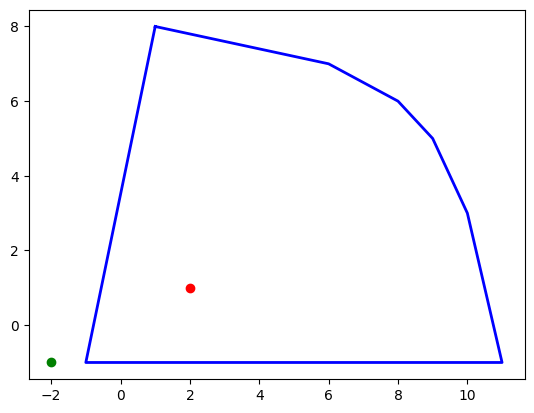

In [21]:
import matplotlib.pyplot as plt

# Given points
A = [1, 8]
B = [6, 7]
C = [8, 6]
D = [9, 5]
E = [10, 3]
F = [11, -1]
G = [-1, -1]
default_point_1 = [2, 1]
default_point_2 = [-2, -1]

# Convex hull
convex_hull = [A, B, C, D, E, F, G, A]
x, y = zip(*convex_hull)

# Plotting
fig, ax = plt.subplots()
ax.plot(x, y, 'b-', linewidth=2)
ax.plot(default_point_1[0], default_point_1[1], 'ro')
ax.plot(default_point_2[0], default_point_2[1], 'go')
plt.show()